In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ratings_df_slim = pd.read_csv('../dataset/XWines_Slim_150K_ratings.csv')
wines_df_slim = pd.read_csv('../dataset/XWines_Slim_1K_wines.csv')


C:\Users\nikch\AppData\Local\Temp\ipykernel_10876\186006784.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df_slim = pd.read_csv('../dataset/XWines_Slim_150K_ratings.csv')


In [3]:
ratings_df_slim = ratings_df_slim.rename(columns={'UserID': 'user', 'WineID': 'item', 'Rating': 'rating', 'Date': 'timestamp'})
wines_df_slim = wines_df_slim.rename(columns={'WineID': 'item'})


In [4]:
def label_rating(rating):
    if rating <= 3.5: #~41%
        return 0
    elif rating == 4.0: #~36%
        return 1
    elif 4.5 <= rating <= 5.0: #~22%
        return 2

In [5]:
ratings_df_slim['rating_label'] = ratings_df_slim['rating'].apply(label_rating)


In [6]:
ratings_df_slim.drop(columns=['timestamp', 'Vintage'], inplace=True) # The Rating Label substitutes the rating column 


In [7]:
display(ratings_df_slim.head())

,RatingID,user,item,rating,rating_label
0,143,1356810,103471,4.5,2
1,199,1173759,111415,5.0,2
2,348,1164877,111395,5.0,2
3,374,1207665,111433,5.0,2
4,834,1075841,111431,5.0,2


In [8]:
# Define the minimum number of ratings required
MIN_RATINGS = 5

# Calculate the original number of unique users
original_user_count = ratings_df_slim['user'].nunique()
print(f"Original number of users: {original_user_count}")

# Filter out users with fewer than MIN_RATINGS by reassigning back to ratings_df_slim
ratings_df_slim = ratings_df_slim.groupby('user').filter(lambda x: len(x) >= MIN_RATINGS)

# Calculate the number of unique users after filtering
filtered_user_count = ratings_df_slim['user'].nunique()
print(f"Number of users after filtering: {filtered_user_count}")

# Optional: Calculate the number of users removed
removed_user_count = original_user_count - filtered_user_count
print(f"Number of users removed: {removed_user_count}")


Original number of users: 10561
Number of users after filtering: 10254
Number of users removed: 307


In [9]:
import random
random.seed(42)

In [10]:
from sklearn.model_selection import train_test_split

# Initialize an array to store user IDs where stratified split failed
failed_strat_users = []  # Normal Split will be used for these users
X_train_total = pd.DataFrame()
X_test_total = pd.DataFrame()
y_train_total = pd.DataFrame()
y_test_total = pd.DataFrame()

# Go through all the users
for user in ratings_df_slim['user'].unique():
    
    # Get all the ratings for the current user
    user_ratings = ratings_df_slim[ratings_df_slim['user'] == user]
    
    
    y = user_ratings['rating_label']
    X = user_ratings.drop(columns='rating_label')

    
    # Attempt to split the data into training and testing sets with stratification
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
    except ValueError as e:
        # Stratified split failed; fallback to regular split
        # Instead of printing, append the user ID to failed_strat_users
        failed_strat_users.append(user)  
        
        # Perform a regular split without stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
    
    # Append to the overall training and testing datasets
    X_train_total = pd.concat([X_train_total, X_train])
    X_test_total = pd.concat([X_test_total, X_test])
    y_train_total = pd.concat([y_train_total, y_train])
    y_test_total = pd.concat([y_test_total, y_test])
    

In [11]:
display(X_test_total)

,RatingID,user,item,rating
143446,20713861,1356810,168128,3.0
4083,189235,1356810,112084,5.0
140537,20579792,1356810,180923,4.0
94433,12880375,1356810,113489,4.0
71336,9395199,1173759,111434,4.0
...,...,...,...,...
139293,20391560,1017473,192359,3.0
132739,19264678,1017473,163365,4.0
138313,20228543,1014021,179024,3.5
135726,19800351,1014021,179012,4.0


In [12]:
display(y_test_total)

,0
143446,0.0
4083,2.0
140537,1.0
94433,1.0
71336,1.0
...,...
139293,0.0
132739,1.0
138313,0.0
135726,1.0


In [13]:
from lenskit.algorithms.user_knn import UserUser
from lenskit.algorithms.item_knn import ItemItem
from lenskit import Recommender

training_data = pd.concat([X_train_total, y_train_total], axis=1)
# Train Item-Item Model
ii_model = ItemItem(15, min_nbrs=3)
recs_ii = Recommender.adapt(ii_model)
recs_ii.fit(training_data[['user', 'item', 'rating']])

# Train User-User Model
uu_model = UserUser(15, min_nbrs=3)
recs_uu = Recommender.adapt(uu_model)
recs_uu.fit(training_data[['user', 'item', 'rating']])


Numba is using threading layer omp - consider TBB
found 1 potential runtime problems - see https://boi.st/lkpy-perf
C:\Users\nikch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lenskit\algorithms\item_knn.py:119: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  b = blocks[bi]


In [75]:
from sklearn import metrics
from lenskit.metrics import topn

def label_rating(rating):
    if rating <= 3.75:
        return 0
    elif rating < 4.25:
        return 1
    elif rating >= 4.25:
        return 2
    else:
        return 0  # Default case for any unexpected values

def evaluate_model(model, X_test, y_test):
    # Generate predictions
    raw_predictions = model.predict(X_test)
    
    # Convert predictions to a DataFrame
    predictions = pd.DataFrame({'prediction': raw_predictions})
    
    predictions.index.name = 'index'
    predictions = predictions.reset_index()
    
    
    # Apply label_rating to the predictions
    predictions['rating_label'] = predictions['prediction'].apply(label_rating)
    
    # Ensure y_test is in the correct format
    y_true = y_test.values.ravel()
    y_pred = predictions['rating_label'].values
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    conf_matrix = metrics.confusion_matrix(y_true, y_pred)

    print(f'accuracy: {accuracy}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'f1: {f1}')
    
    
    # Compute nDCG@10 for each user using the index
    for user_id in X_test_total['user'].unique():
        # Get the true ratings for the current user
        user_test_data = y_test_total[X_test_total['user'] == user_id]
        user_predictions = predictions[predictions['index'].isin(user_test_data.index)]
        
        # Extract true and predicted ratings
        y_test_user = user_test_data.values.ravel()  # Flatten to ensure 1D array
        y_pred_user = user_predictions['rating_label'].values  # Extract prediction labels for this user

        if len(y_test_user) == 0 or len(y_pred_user) == 0:
            continue  # Skip if there's no data for the user
        
        # Compute nDCG for the current user
        ndcg = compute_ndcg(y_test_user, y_pred_user, k=10, relevance_mapping={0: 0, 1: 1, 2: 2})
        ndcg_list.append(ndcg)

    # Compute average nDCG
    avg_ndcg = np.mean(ndcg_list)
    print(f'Average nDCG@10: {avg_ndcg}')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'conf_matrix': conf_matrix,
        'avg_ndcg': avg_ndcg
    }


In [74]:
# Train Item-Item Model
ii_model = ItemItem(15, min_nbrs=3)
recs_ii = Recommender.adapt(ii_model)
recs_ii.fit(training_data[['user', 'item', 'rating']])

# Train User-User Model
uu_model = UserUser(5, min_nbrs=3)
recs_uu = Recommender.adapt(uu_model)
recs_uu.fit(training_data[['user', 'item', 'rating']])
# Evaluate User-User model
print("Metrics: User-User")
uu_metrics = evaluate_model(recs_uu, X_test_total, y_test_total)
# Evaluate Item-Item model
print("Metrics: Item-Item")
ii_metrics = evaluate_model(recs_ii, X_test_total, y_test_total)


Metrics: User-User
accuracy: 0.5947718236306451
precision: 0.6016770215440063
recall: 0.5694521164066032
f1: 0.5767797503469901
Average nDCG@10: 0.8147645097188465
Average nDCG@20: 0.8147645097188465
Metrics: Item-Item
accuracy: 0.6557474333867426
precision: 0.660723247245005
recall: 0.6418961189442082
f1: 0.6481972864134904
Average nDCG@10: 0.8194048943192526
Average nDCG@20: 0.8194048943192526


In [46]:
uu_conf_matrix = uu_metrics['conf_matrix']
ii_conf_matrix = ii_metrics['conf_matrix']

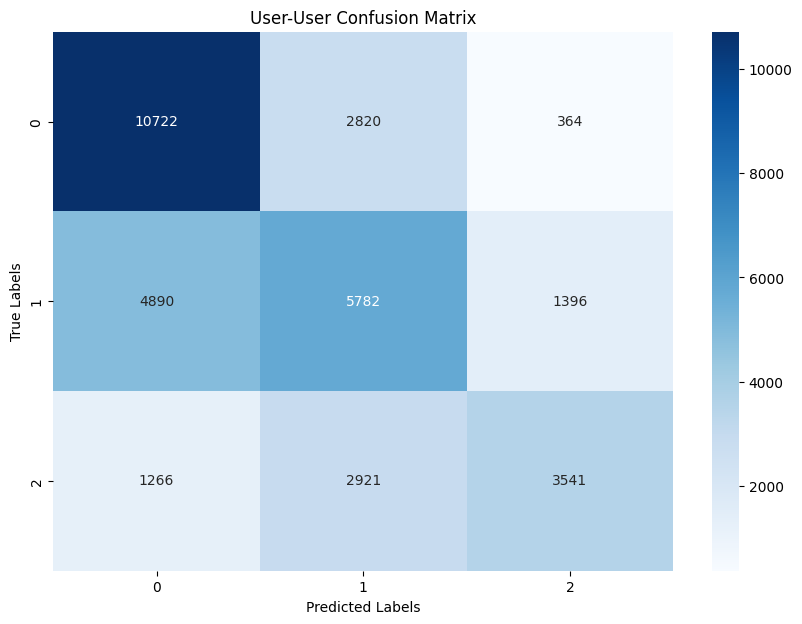

In [47]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(uu_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2],
            yticklabels=[0,1,2])
plt.title('User-User Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

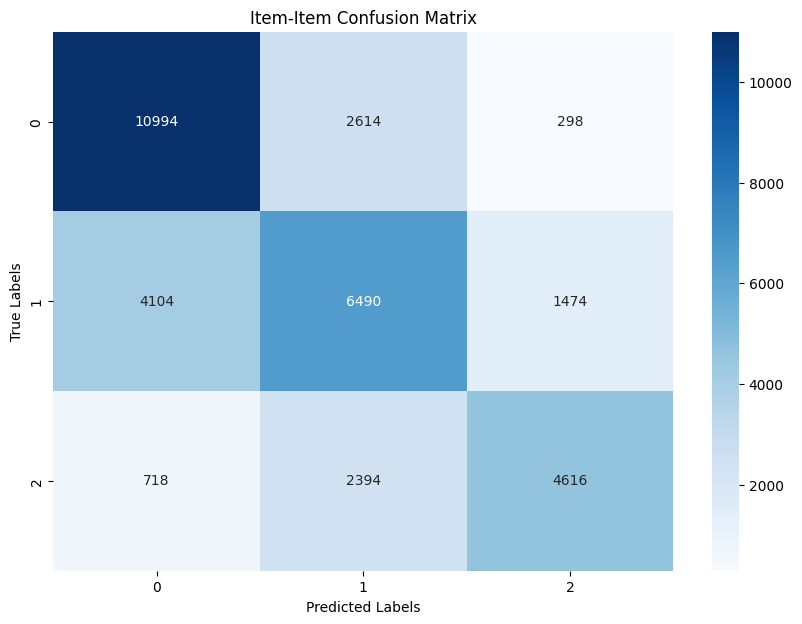

In [48]:
plt.figure(figsize=(10, 7))
sns.heatmap(ii_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2],
            yticklabels=[0,1,2])
plt.title('Item-Item Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [24]:
# Define the values of k to tune
k_values = [3, 5, 10, 15, 20]

# Dictionary to store the results
results = {
    'k': [],
    'model': [],
    'similarity': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

# Loop over different values of k and similarity measures
for k in k_values:
        # Train and evaluate Item-Item model
        ii_model = item_knn.ItemItem(k, min_nbrs=3)
        recs_ii = Recommender.adapt(ii_model)
        recs_ii.fit(training_data[['user', 'item', 'rating']])
        ii_metrics = evaluate_model(recs_ii, X_test_total, y_test_total)

        # Store results for item-item model
        results['k'].append(k)
        results['model'].append('Item-Item')
        results['similarity'].append(similarity_measure)
        results['accuracy'].append(ii_metrics['accuracy'])
        results['precision'].append(ii_metrics['precision'])
        results['recall'].append(ii_metrics['recall'])
        results['f1'].append(ii_metrics['f1'])

        # Train and evaluate User-User model
        uu_model = user_knn.UserUser(k, min_nbrs=3)
        recs_uu = Recommender.adapt(uu_model)
        recs_uu.fit(training_data[['user', 'item', 'rating']])
        uu_metrics = evaluate_model(recs_uu, X_test_total, y_test_total)

        # Store results for user-user model
        results['k'].append(k)
        results['model'].append('User-User')
        results['similarity'].append(similarity_measure)
        results['accuracy'].append(uu_metrics['accuracy'])
        results['precision'].append(uu_metrics['precision'])
        results['recall'].append(uu_metrics['recall'])
        results['f1'].append(uu_metrics['f1'])



accuracy: 0.6340276541451546
precision: 0.6336847974258868
recall: 0.6239332642695793
f1: 0.6268008971971998
accuracy: 0.5830811227820307
precision: 0.5846639159579116
recall: 0.5602403839536113
f1: 0.5664838419997716
accuracy: 0.648655866120705
precision: 0.6514237144930609
recall: 0.6360840080175638
f1: 0.6411309315341941
accuracy: 0.5947718236306451
precision: 0.6016770215440063
recall: 0.5694521164066032
f1: 0.5767797503469901
accuracy: 0.6550946531363124
precision: 0.6595534475474838
recall: 0.6413769633399236
f1: 0.6474402614218836
accuracy: 0.5910628449350187
precision: 0.60691122403178
recall: 0.5610270059062538
f1: 0.5680576118809206
accuracy: 0.6557474333867426
precision: 0.660723247245005
recall: 0.6418961189442082
f1: 0.6481972864134904
accuracy: 0.5799952525072696
precision: 0.6019822105216246
recall: 0.5456753606026227
f1: 0.5509407408451963
accuracy: 0.6559254643641327
precision: 0.6609028354446381
recall: 0.6420700568482399
f1: 0.6483747468066566
accuracy: 0.56880897276

In [27]:
results_df = pd.DataFrame(results)
results_df['similarity'] = 'cosine'
display(results_df)

,k,model,similarity,accuracy,precision,recall,f1
0,3,Item-Item,cosine,0.634028,0.633685,0.623933,0.626801
1,3,User-User,cosine,0.583081,0.584664,0.560240,0.566484
2,5,Item-Item,cosine,0.648656,0.651424,0.636084,0.641131
3,5,User-User,cosine,0.594772,0.601677,0.569452,0.576780
4,10,Item-Item,cosine,0.655095,0.659553,0.641377,0.647440
5,10,User-User,cosine,0.591063,0.606911,0.561027,0.568058
6,15,Item-Item,cosine,0.655747,0.660723,0.641896,0.648197
7,15,User-User,cosine,0.579995,0.601982,0.545675,0.550941
8,20,Item-Item,cosine,0.655925,0.660903,0.642070,0.648375
9,20,User-User,cosine,0.568809,0.596461,0.530743,0.533963


item-item 5/10 neighbours gives the majority of benefits afterwards marginal improvement

In [29]:
item_item_results = results_df[results_df['model'] == 'Item-Item']
display(item_item_results)

,k,model,similarity,accuracy,precision,recall,f1
0,3,Item-Item,cosine,0.634028,0.633685,0.623933,0.626801
2,5,Item-Item,cosine,0.648656,0.651424,0.636084,0.641131
4,10,Item-Item,cosine,0.655095,0.659553,0.641377,0.647440
6,15,Item-Item,cosine,0.655747,0.660723,0.641896,0.648197
8,20,Item-Item,cosine,0.655925,0.660903,0.642070,0.648375


In [50]:
user_user_results = results_df[results_df['model'] == 'User-User']
display(user_user_results)

,k,model,similarity,accuracy,precision,recall,f1
1,3,User-User,cosine,0.583081,0.584664,0.560240,0.566484
3,5,User-User,cosine,0.594772,0.601677,0.569452,0.576780
5,10,User-User,cosine,0.591063,0.606911,0.561027,0.568058
7,15,User-User,cosine,0.579995,0.601982,0.545675,0.550941
9,20,User-User,cosine,0.568809,0.596461,0.530743,0.533963


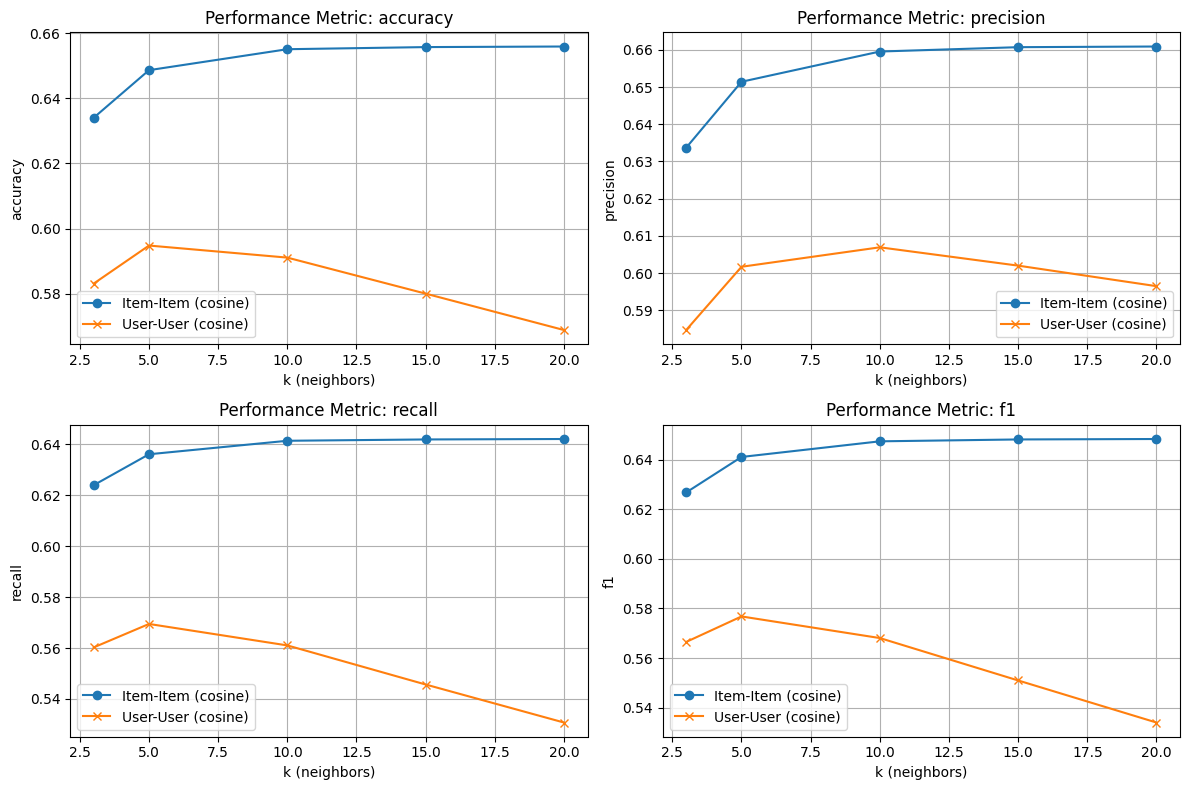

In [28]:
# Convert results to a DataFrame for easier plotting
import matplotlib.pyplot as plt
import pandas as pd

# Plot the results
plt.figure(figsize=(12, 8))

for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.subplot(2, 2, ['accuracy', 'precision', 'recall', 'f1'].index(metric) + 1)
    
    # Plot Item-Item cosine and euclidean
    plt.plot(results_df[(results_df['model'] == 'Item-Item') & (results_df['similarity'] == 'cosine')]['k'], 
             results_df[(results_df['model'] == 'Item-Item') & (results_df['similarity'] == 'cosine')][metric], 
             label='Item-Item (cosine)', marker='o')
    # plt.plot(results_df[(results_df['model'] == 'Item-Item') & (results_df['similarity'] == 'euclidean')]['k'], 
    #          results_df[(results_df['model'] == 'Item-Item') & (results_df['similarity'] == 'euclidean')][metric], 
    #          label='Item-Item (euclidean)', marker='o')
    
    # Plot User-User cosine and euclidean
    plt.plot(results_df[(results_df['model'] == 'User-User') & (results_df['similarity'] == 'cosine')]['k'], 
             results_df[(results_df['model'] == 'User-User') & (results_df['similarity'] == 'cosine')][metric], 
             label='User-User (cosine)', marker='x')
    # plt.plot(results_df[(results_df['model'] == 'User-User') & (results_df['similarity'] == 'euclidean')]['k'], 
    #          results_df[(results_df['model'] == 'User-User') & (results_df['similarity'] == 'euclidean')][metric], 
    #          label='User-User (euclidean)', marker='x')

    plt.title(f'Performance Metric: {metric}')
    plt.xlabel('k (neighbors)')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Define the compute_ndcg function
def compute_ndcg(y_test, y_pred, k=10, relevance_mapping=None):
    """
    Computes the Normalized Discounted Cumulative Gain (nDCG) at rank k.

    Parameters:
    - y_test (list or array): True class labels.
    - y_pred (list or array): Predicted class labels.
    - k (int): Rank position to compute nDCG up to. Default is 10.
    - relevance_mapping (dict): Mapping from class labels to relevance scores.
                                 If None, assumes labels are already relevance scores.
                                 Example: {0: 0, 1: 1, 2: 2}

    Returns:
    - ndcg (float): The nDCG@k score.
    """
    if relevance_mapping:
        # Map true labels to relevance scores
        y_true_relevance = [relevance_mapping.get(label, 0) for label in y_test]
    else:
        y_true_relevance = list(y_test)
    
    # Create a list of item indices
    item_ids = list(range(len(y_test)))

    # Create a list of tuples: (Item_ID, True_Relevance, Predicted_Label)
    items = list(zip(item_ids, y_true_relevance, y_pred))

    # Sort items based on Predicted_Label in descending order to get ranking
    items_sorted = sorted(items, key=lambda x: x[2], reverse=True)

    # Truncate the list to top k items
    top_k = items_sorted[:k]

    # Compute DCG@k
    dcg = 0.0
    for i, item in enumerate(top_k):
        rel = item[1]
        gain = 2 ** rel - 1
        discount = np.log2(i + 2)  # Positions are 1-based in nDCG
        dcg += gain / discount

    # Compute IDCG@k by sorting true relevance in descending order
    ideal_sorted_relevance = sorted(y_true_relevance, reverse=True)[:k]

    idcg = 0.0
    for i, rel in enumerate(ideal_sorted_relevance):
        gain = 2 ** rel - 1
        discount = np.log2(i + 2)
        idcg += gain / discount

    # Handle the case where IDCG is 0
    if idcg == 0:
        return 0.0

    ndcg = dcg / idcg
    return ndcg

In [78]:
def calculate_unique_item_percentage(model, users, num_unique_items, N=10):
    """
    Calculates the percentage of unique items recommended in the Top-N list for a given model.
    
    Parameters:
    - model: The trained LensKit model (User-User or Item-Item).
    - users: The list of user IDs for whom recommendations are generated.
    - N: The number of top recommendations to consider (e.g., 10 or 100).
    
    Returns:
    - percentage_unique_items: The percentage of unique items recommended in the Top-N lists.
    """
    all_recommended_items = []
    
    # Generate Top-N recommendations for each user
    for user in users:
        top_n_recs = model.recommend(user, N)  
        recommended_items = top_n_recs['item'].tolist()
        all_recommended_items.extend(recommended_items)
    
    # Calculate the number of unique items recommended
    unique_items = set(all_recommended_items)
    num_unique_items_recommended = len(unique_items)

    return (num_unique_items_recommended / num_unique_items) * 100

In [81]:
# Get the list of unique users from the test set
user_ids = X_train_total['user'].unique()
unique_wines = X_train_total['item'].nunique()

# Calculate the percentage of unique wines for User-User model (Top 10)
print("User-User Model")
uu_top_10 = calculate_unique_item_percentage(recs_uu, user_ids, unique_wines, N=10)
uu_top_100 = calculate_unique_item_percentage(recs_uu, user_ids, unique_wines, N=100)
print(f"Percentage of unique wines recommended in the Top 10: {uu_top_10:.2f}%")
print(f"Percentage of unique wines recommended in the Top 100: {uu_top_100:.2f}%")

# Calculate the percentage of unique wines for Item-Item model (Top 10)
print("Item-Item Model")
ii_top_10 = calculate_unique_item_percentage(recs_ii, user_ids, unique_wines, N=10)
ii_top_100 = calculate_unique_item_percentage(recs_ii, user_ids, unique_wines, N=100)
print(f"Percentage of unique wines recommended in the Top 10: {ii_top_10:.2f}%")
print(f"Percentage of unique wines recommended in the Top 100: {ii_top_100:.2f}%")


User-User Model
Percentage of unique wines recommended in the Top 10: 47.39%
Percentage of unique wines recommended in the Top 100: 83.23%
Item-Item Model
Percentage of unique wines recommended in the Top 10: 47.39%
Percentage of unique wines recommended in the Top 100: 90.46%
